## Accessing Data in Cloud-Optimized GeoTIFFs (COGs) with R

Cloud-Optimized GeoTIFFs (COGs) are a sub-specification of GeoTIFF which is, itself, a sub-specification of TIFF. It exists to store raster data with a 2D aligned grid in a fashion optimized for cloud environments. They enable efficient, scalable workflows for geospatial analysis and are increasingly used in remote sensing and GIS.

### Key Benefits of COGs:

- **Subset Access**: Access specific regions or bands of data without downloading the entire file.
- **Cost Savings**: By avoiding full downloads, COGs help reduce storage and data transfer costs, which is especially important when using pay-as-you-go cloud services.
- **Faster Workflows**: On-demand, region specific access improves the speed of tasks such as visualization, analysis, and processing, making workflows more responsive and scalable.
- **Interoperability**: COGs are supported by a wide range of geospatial tools and libraries, making them easy to integrate into diverse workflows.
- **Built-in Pyramids**: COGs include lower-resolution overviews of the data they store so that previews of the data from a 'zoomed out' perspective don't require reading the entire image followed by resampling.

---

### Demonstration Goals:

This notebook will showcase how COGs enable efficient geospatial data access in R by:

1. **Accessing Metadata with `gdalinfo`**:
   - Using the `gdalinfo` utility to inspect the metadata of the Cloud-Optimized GeoTIFF.
   - Extracting information about dimensions, resolution, projection, internal tiling structure, and available overviews.

2. **Visualizing the Internal Tiling Structure**:
   - Overlaying the raster with grid lines representing the internal 1024x1024 tile boundaries.
   - Highlighting a specific window on the raster that spans multiple tiles, illustrating the importance of tile alignment for efficient data access.

3. **Reading and Visualizing Specific Regions**:
   - Extracting a 1024x1024 region aligned with a single internal tile to demonstrate optimal access.
   - Extracting a 1024x1024 region spanning multiple tiles to demonstrate a less-optimal case where more data must be read.

---

### Key Takeaways:

- The **`gdalinfo` step** provides essential metadata, including the internal tiling structure, which is crucial for understanding how COGs optimize access.
- COGs make it possible to access specific regions of a raster efficiently, reducing bandwidth and storage costs.
- Aligning requests with the internal tile grid minimizes unnecessary data transfer and maximizes performance.
- Even in less-optimal cases where requests span multiple tiles, COGs still outperform traditional raster formats by enabling targeted data access.

This notebook highlights how R, combined with `terra`, provides powerful tools for working with COGs in cloud-native geospatial workflows.

### Setting Up for Cloud-Optimized GeoTIFF (COG) Access with `terra`

This section configures the environment and prepares terra to access a Cloud-Optimized GeoTIFF (COG) hosted on AWS.

#### 1. Loading terra
The only library required for this workflow is **`terra`**, which provides powerful tools for geospatial data analysis in R.

#### 2. Configuring the environment
To enable seamless access to publicly accessible data on AWS:
- **Anonymous Access**:
  - AWS-hosted public datasets allow anonymous access without credentials. This is enabled by setting the `AWS_NO_SIGN_REQUEST` environment variable to `"YES"`. This configuration ensures that GDAL makes unsigned requests when accessing the file.
  
- **Metadata from File Header**:
  - By setting the `GDAL_DISABLE_READDIR_ON_OPEN` environment variable to `"EMPTY_DIR"`, we inform GDAL that all necessary metadata is contained within the file header. This avoids unnecessary checks for external "sidecar" metadata files, improving efficiency.

For more configuration options, consult the [GDAL configuration documentation](https://gdal.org/en/stable/user/configoptions.html).

#### 3. Defining the COG URL
The file is accessed using its virtual filesystem (VSI) path:
- The path `/vsis3/` indicates that the file is hosted on Amazon S3.
- This example points to a Sentinel-2 COG available in the public Sentinel COG dataset. 
- GDAL supports other virtual filesystems, including `http`, `zip`, `tar`, and combinations thereof. For details, see [GDAL virtual filesystem documentation](https://gdal.org/en/stable/user/virtual_file_systems.html).

#### 4. Opening the COG and Inspecting Metadata
Using the `rast()` function from `terra`, we create a reference to the COG:
- **Important Note**: No data is downloaded at this stage! Only the file's metadata is read.
- Metadata includes details such as resolution, coordinate reference system (CRS), and geographic extent, which can be accessed immediately without fetching pixel data.

In [1]:
library(terra)

setGDALconfig("AWS_NO_SIGN_REQUEST", "YES")
setGDALconfig("GDAL_DISABLE_READDIR_ON_OPEN", "EMPTY_DIR")

cog_url <- "/vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif"
r <- rast(cog_url)
print(r)

terra 1.7.29



class       : SpatRaster 
dimensions  : 10980, 10980, 1  (nrow, ncol, nlyr)
resolution  : 10, 10  (x, y)
extent      : 3e+05, 409800, 3290220, 3400020  (xmin, xmax, ymin, ymax)
coord. ref. : WGS 84 / UTM zone 12N (EPSG:32612) 
source      : B02.tif 
name        : B02 


### Exploring Metadata with `gdalinfo`

Before diving further into visualization or analysis, it's essential to understand the structure and metadata of the Cloud-Optimized GeoTIFF (COG) we're working with. Metadata provides critical insights about the file, such as:

- **Dimensions**: The raster's size in pixels.
- **Projection**: The coordinate reference system (CRS) used for the dataset.
- **Resolution**: The pixel size in geographic or projected units.
- **Tile Information**: The internal structure of the COG (e.g., block size and block layout).
- **Overviews**: Precomputed lower-resolution representations for efficient access.
- **Statistics**: Summary statistics about the dataset's pixel values.

In the following cell, we use the `gdalinfo` command to retrieve this metadata. This step helps verify the internal structure of the TIFF and confirm details like tile size, overview levels, and compression, which are crucial for understanding data access and performance characteristics.

In [2]:
# We can use gdalinfo to inspect the tiff's metadata
# NOTE: we'll need to add `AWS_NO_SIGN_REQUEST` to the environment variables for the following command line arguments to respect it!
Sys.setenv(AWS_NO_SIGN_REQUEST = "YES")

gdalinfo <- system2("gdalinfo", args = c("-stats", cog_url), stdout = TRUE)
cat(gdalinfo, sep = "\n")

Driver: GTiff/GeoTIFF
Files: /vsis3/sentinel-cogs/sentinel-s2-l2a-cogs/12/R/UU/2024/4/S2A_12RUU_20240421_0_L2A/B02.tif
Size is 10980, 10980
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 12N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 12N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-111,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,

### Visualizing the Internal Tile Grid of the COG

After inspecting the metadata with `gdalinfo`, we can use the extracted information to visualize the internal tile grid of the Cloud-Optimized GeoTIFF (COG). This visualization helps confirm how the file is divided into tiles and ensures our understanding aligns with the metadata.

In this cell, we:

1. **Calculate Block Size in Geographic Units**:
   - Using the block size in pixels (from the metadata, typically 1024x1024 for Sentinel-2 COGs) and the raster's resolution, we compute the corresponding geographic dimensions of each tile.

2. **Generate Grid Coordinates**:
   - Grid lines are defined by the tile boundaries. The code to generate such a grid is included in the collapsed code block below.
   - Horizontal (`x`) and vertical (`y`) grid coordinates are calculated to align with the raster's extent, ensuring proper alignment starting from the top-left corner (consistent with COG tiling).

3. **Overlay the Grid on the Raster**:
   - The raster is plotted at a low resolution (using overviews, if available) for performance.
   - Red grid lines are drawn to represent the tile boundaries.
   - The blue rectangle corresponds to the region or window we'll be plotting.

This visualization depicts the COG's internal tiling structure, which is crucial for efficient access to specific regions of the COG.

In [3]:
# COG statistics we'll want to use later
block_size_pixels <- 1024  # Tile size in pixels
r_extent <- ext(r)         # Extent of the raster (total geographic units)
r_res <- res(r)            # Resolution of the raster (units per pixel)

# Calculate block size in geographic units
block_size_x <- block_size_pixels * r_res[1]
block_size_y <- block_size_pixels * r_res[2]

# Define the boundaries of the first tile
first_tile_xmin <- xmin(r_extent)
first_tile_xmax <- xmin(r_extent) + block_size_x
first_tile_ymin <- ymax(r_extent) - block_size_y
first_tile_ymax <- ymax(r_extent)

Warning message in plot.window(...):
“"overview" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"overview" is not a graphical parameter”
Warning message in title(...):
“"overview" is not a graphical parameter”


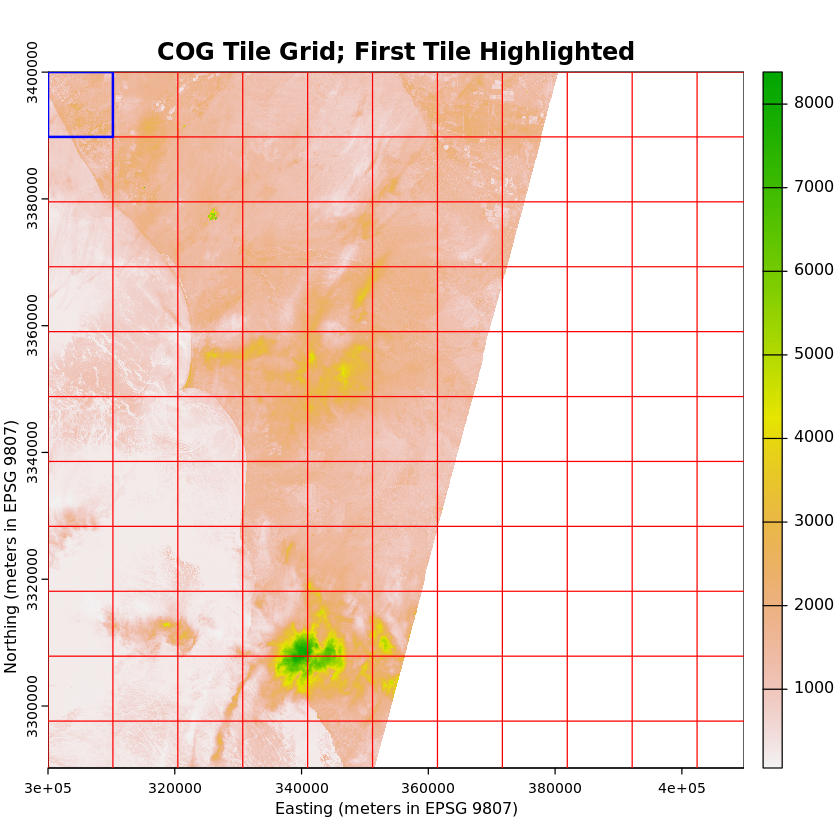

In [4]:
# Plot the tif preview with grid
plot(
  r,
  main = "COG Tile Grid; First Tile Highlighted",
  overview = TRUE,
  xlab = "Easting (meters in EPSG 9807)",
  ylab = "Northing (meters in EPSG 9807)"
)

# Generate grid coordinates
x_coords <- seq(xmin(r_extent), xmax(r_extent), by = block_size_x)

# Reverse y_coords to start from the top (ymax) and move down
y_coords <- seq(ymax(r_extent), ymin(r_extent), by = -block_size_y)

# Add vertical grid lines
for (x in x_coords) {
  lines(c(x, x), c(ymin(r_extent), ymax(r_extent)), col = "red")
}

# Add horizontal grid lines
for (y in y_coords) {
  lines(c(xmin(r_extent), xmax(r_extent)), c(y, y), col = "red")
}

# Draw the rectangle
rect(
  first_tile_xmin,
  first_tile_ymin,
  first_tile_xmax,
  first_tile_ymax,
  border = "blue", lwd = 2
)

### Extracting and Visualizing the First Full Tile (Top-Left 1024x1024 Block)

In this step, we extract the **first full tile** (a 1024x1024 block) of the dataset, aligned with the internal tiling structure of the Cloud-Optimized GeoTIFF (COG). This demonstrates the efficiency of accessing tiles directly, as COGs enable on-demand retrieval of specific data blocks without downloading the entire file.

#### Steps Performed:
1. **Define the Extent**:
   - The geographic extent of the first tile is calculated, starting from the top-left corner of the raster's full extent and spanning the dimensions of one full tile.

2. **Crop the Raster**:
   - Using Terra's `crop` method, the raster is cropped to the calculated extent to retrieve only the first tile.

3. **Visualize the Tile**:
   - The cropped tile is plotted to confirm its alignment with the internal tiling structure.

This process demonstrates a best-case scenario for access efficiency: all and only the bytes necessary for the selected region are read. While this level of optimization isn't necessary, it illustrates how COGs can minimize data access. In most workflows, reading a few extra bytes is acceptable, but the ability to avoid processing the bulk of a large TIFF is a major advantage enabled by this per-tile access.

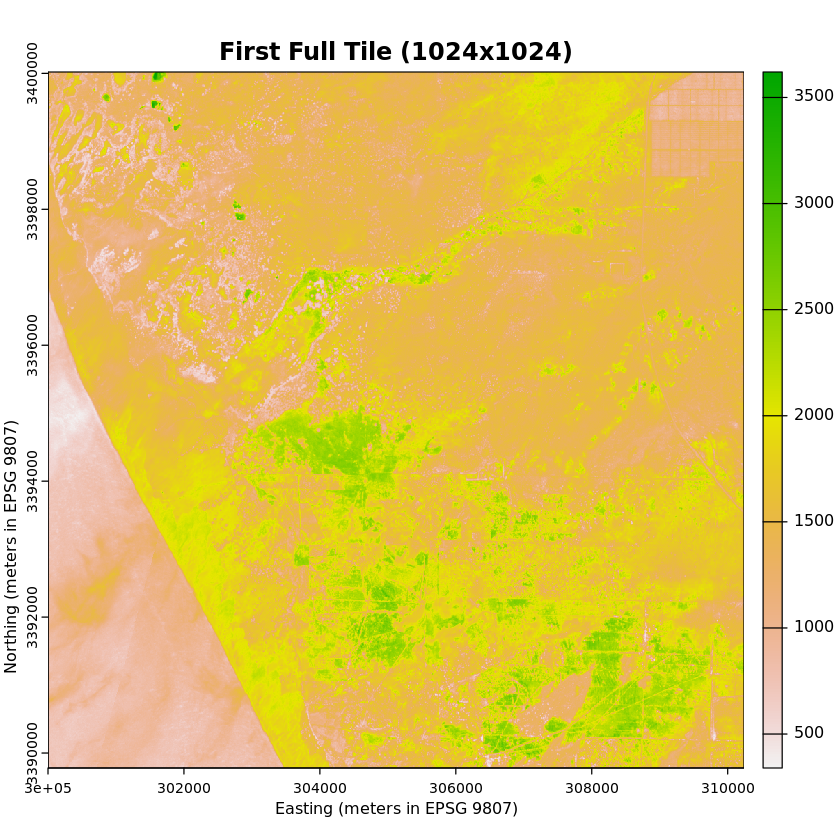

In [5]:
first_tile_extent = ext(
    first_tile_xmin,
    first_tile_xmax,
    first_tile_ymin,
    first_tile_ymax
)

# Crop the raster to the defined extent
first_tile <- crop(r, first_tile_extent)

# Visualize the first tile
plot(
  first_tile,
  main = "First Full Tile (1024x1024)",
  xlab = "Easting (meters in EPSG 9807)",
  ylab = "Northing (meters in EPSG 9807)"
)

### Visualizing a Region Spanning Multiple Tiles

In this step, we visualize a **1024x1024 region** (the same size as above). This time, however, the window we construct will span portions of 4 internal tiles. This is a less-optimal case because multiple tiles must be accessed to satisfy a single request. From the point of view of someone using the API, things remain seamless. But behind the scenes, 4 times the data is being requested compared to the request above which aligned neatly with the internal tile grid.

#### Steps:
1. **Define the Extent Centered on a Tile Intersection**:
   - The region is centered on the intersection of 4 tiles, ensuring it overlaps multiple internal blocks of the TIFF.
   - Red grid lines represent the boundaries of the internal tiles, showing how the request spans these blocks.

2. **Visualize the Region**:
   - The blue rectangle highlights the requested region, superimposed over the red tile grid lines. This illustrates which tiles will need to be accessed to satisfy the request.

#### Insights:
- The red grid lines illustrate the boundaries of the COG's internal tiling, highlighting the efficiency of accessing data aligned with these tiles.
- The blue rectangle represents the requested region, showing how it spans multiple tiles.
- This step is purely visual: no reading or cropping data yet.

In [6]:
# Determine the center point where 4 tiles intersect
center_x <- xmin(r) + block_size_x
center_y <- ymax(r) - block_size_y

# Define the 1024x1024 window centered on this point
four_tile_xmin <- center_x - (block_size_x / 2)
four_tile_xmax <- center_x + (block_size_x / 2)
four_tile_ymin <- center_y - (block_size_y / 2)
four_tile_ymax <- center_y + (block_size_y / 2)

Warning message in plot.window(...):
“"overview" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"overview" is not a graphical parameter”
Warning message in title(...):
“"overview" is not a graphical parameter”


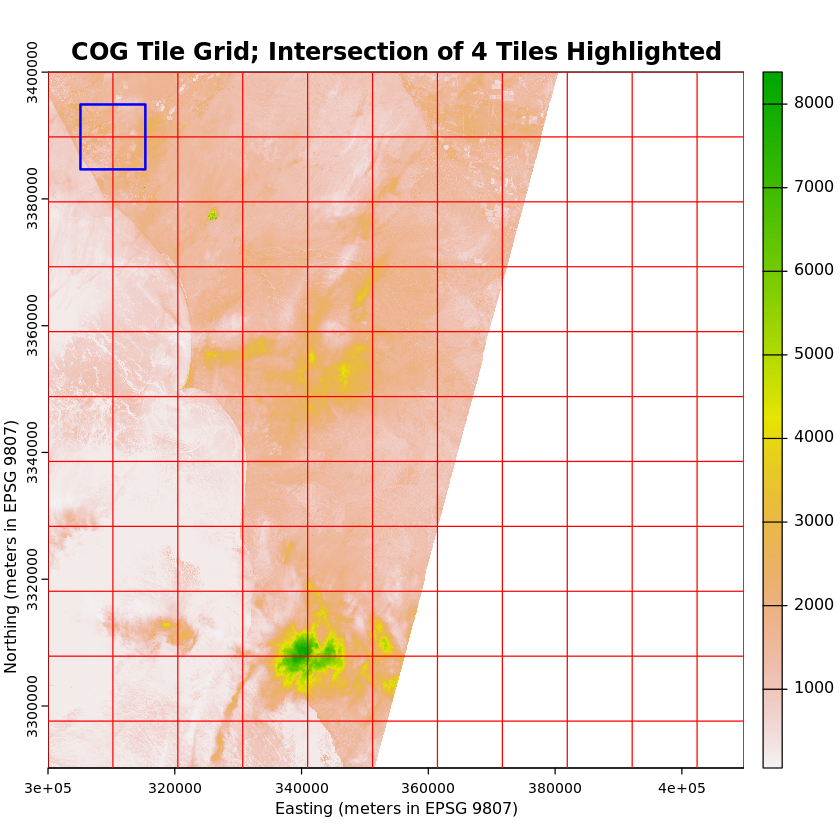

In [7]:
# Plot the tif preview with grid
plot(
  r,
  main = "COG Tile Grid; Intersection of 4 Tiles Highlighted",
  overview = TRUE,
  xlab = "Easting (meters in EPSG 9807)",
  ylab = "Northing (meters in EPSG 9807)"
)

# Add grid lines to show individual tiles
x_coords <- seq(xmin(r), xmax(r), by = block_size_x)
y_coords <- seq(ymax(r), ymin(r), by = -block_size_y)

for (x in x_coords) {
  lines(c(x, x), c(ymin(r), ymax(r)), col = "red")
}
for (y in y_coords) {
  lines(c(xmin(r), xmax(r)), c(y, y), col = "red")
}

# Highlight the window in blue
rect(
    four_tile_xmin,
    four_tile_ymin,
    four_tile_xmax,
    four_tile_ymax,
    border = "blue",
    lwd = 2
)

### Extracting and Visualizing the Selected Window

In this step, we read the raster data corresponding to the **blue rectangle** visualized in the previous step. This window spans portions of 4 internal tiles. Again, this is a less-optimal case where data from multiple tiles must be accessed to fulfill a single request.

#### Steps:
1. **Read the Window**:
   - Using the previously defined extent (the blue rectangle), we extract the corresponding raster data. 
   - The operation retrieves data from all 4 tiles that overlap with the window.

2. **Visualize the Region**:
   - The extracted region is plotted, confirming its location and spatial coverage within the raster.

#### Insights:
- While the request spans multiple tiles, the ability to target only the relevant portions of the raster remains far more efficient than downloading the entire file.

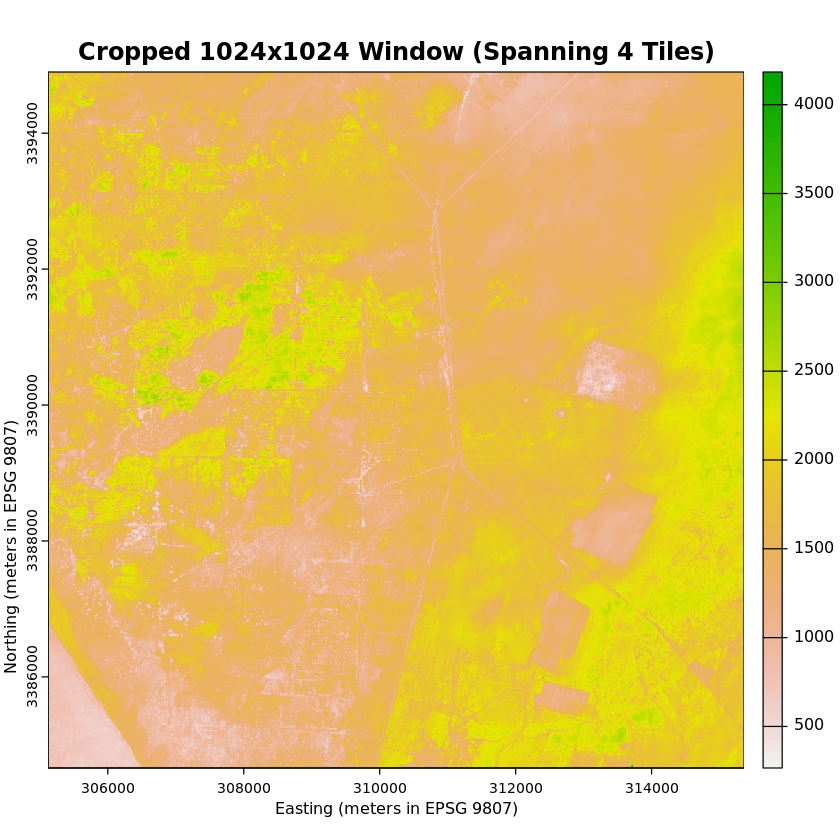

In [8]:
# Create the extent for the window
four_tile_extent <- ext(
    four_tile_xmin,
    four_tile_xmax,
    four_tile_ymin,
    four_tile_ymax
)

# Crop the raster to the 1024x1024 window
window_4_tiles <- crop(r, four_tile_extent)

# Plot the cropped window
plot(
  window_4_tiles,
  main = "Cropped 1024x1024 Window (Spanning 4 Tiles)",
  xlab = "Easting (meters in EPSG 9807)",
  ylab = "Northing (meters in EPSG 9807)"
)

### Review of Key Points

In this notebook, we explored how to efficiently access and process geospatial data stored in a Cloud-Optimized GeoTIFF (COG) using `terra` in R. The key takeaways include:

#### Efficient Data Access:
- COGs allow on-demand access to specific regions of a dataset without requiring the download of the entire file.
- This capability minimizes bandwidth usage, accelerates workflows, and supports scalable analysis of large geospatial datasets.

#### Visualization of Internal Tiling:
- We visualized the internal tile structure of the COG (1024x1024 tiles) by overlaying a grid on the raster. 
- A blue rectangle highlighted the region corresponding to the first tile, illustrating how COGs organize data into blocks for efficient access.

#### Aligned and Unaligned Access:
1. **Aligned Access**:
   - A 1024x1024 region corresponding to the first tile (top-left corner) was extracted.
   - This represents the best-case scenario for COGs, where the requested region aligns perfectly with an internal tile, ensuring minimal data transfer.

2. **Unaligned Access**:
   - A 1024x1024 region spanning portions of 4 tiles was extracted.
   - This less-optimal case demonstrates how misalignment with the internal tile grid increases the amount of data accessed while still avoiding the need to download the entire file.

#### Reflection on Tools:
- The `terra` package provides a powerful and flexible interface for geospatial data processing in R, enabling tasks such as cropping, visualizing, and analyzing raster data.
- By leveraging COG-specific features like internal tiling and on-demand access, workflows can be made more efficient and cost-effective.